Codes needed for reading the files and preparing them for language model generation

In [10]:
from io import FileIO
import re
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')


def extact_sentences(file_path):
  # file_path:path to the trascript file 
  remove = re.compile("[\[\(].*?[\]\)]|particular attention to juror NO\. 8")
  replace = re.compile("FOREMAN:")
  juror_line = re.compile("NO\.\s?(\d+):\s+(.+?)(?=NO\. \d+|$)")

  # key: Jury value: sentence said
  dictionary_lines = {}
  with open(file_path, 'r', encoding="unicode_escape") as file:
    line = file.readline()
    while(line):
      line = re.sub(remove, "", line)
      line = re.sub(replace, 'NO. 1:', line)
      matched_text = re.search(juror_line, line)
      if matched_text:
        if matched_text.group(1) in dictionary_lines:
          dictionary_lines[matched_text.group(1)].append(matched_text.group(2))
        else:
          dictionary_lines[matched_text.group(1)] = [matched_text.group(2)]
      line = file.readline()

  # Remove the intro description of each juror before Act 1
  # No. 10 is formatted without a : 
  for juror in dictionary_lines:
    if juror != '10':
      del dictionary_lines[juror][:1]
  return dictionary_lines

def pre_process_inputs(dictionary_lines):
  from collections import Counter
  # This method takes in the dictionary from previous method
  # It will return two dictionaries: one having all the tokens along
  # with their frequencies (list to counter?)
  # The other dictionary will have jury as the key (e.g., NO.2)
  # and the values are another dictionary of {token: frequency} for each jury
  
  lst_all_words = []
  dictionary_juror_words = {}
  for jury in dictionary_lines:
    lst_sentences_by_jury = dictionary_lines[jury]
    words_juror = []
    for sentence in lst_sentences_by_jury:
      tokenizer = RegexpTokenizer(r'\w+')
      sentence_words = tokenizer.tokenize(sentence)
      for tok in sentence_words:
        words_juror.append(tok.lower())
        lst_all_words.append(tok.lower())
    dictionary_juror_words[jury] = dict(Counter(words_juror)) 

  vocabulary = dict(Counter(lst_all_words))
  return vocabulary, dictionary_juror_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Code to generate languge model

In [11]:
from collections import Counter

def unigram_lm(dict_vocabulary, dict_juror_words):
  # This method will generate the unigram language model for each juror
  # The return value is a dict with juror as key and value as his language model
  # the inputs are the two dictionaries from pre_process_inputs method
  dict_unigram_lm = {}
  for jury in dict_juror_words:
    dict_words_frequency = dict_juror_words[jury]
    language_model = {key: 0 for key in dict_vocabulary}
    # Here you will calculate the probabilities with MLE and add-one smoothing
    for key in language_model: 
      # .get(key, 0), if it can't find key, use zero as the return value then smooth
      nom = dict_words_frequency.get(key, 0) + 1
      denom = dict_vocabulary[key] + 1 * len(dict_vocabulary)
      language_model[key] = float(nom)/float(denom)
    dict_unigram_lm[jury] = language_model
  return dict_unigram_lm

Code to generate T-SNE plot

In [12]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def tsne_generator(dic_unigram_lm):
  tsne = TSNE(n_components=2, random_state = 0)
  lst_freq = []
  lst_names = []
  for juror in dic_unigram_lm:
    juror_name = "Juror #"
    juror_name += juror
    lst_names.append(juror_name)
    
    # frequencies is a dictionary of token: frequencies
    # sort this by key and then convert values to the list and append it 
    # to the lst_freq
    frequencies = dic_unigram_lm[juror]
    ##### 
    # Your code goes here and then remove freq=[0] and instead of [0]
    # save your results in freq

    # Sort frequencies
    sorted_frequencies = sorted(frequencies.items(), key=lambda x:x[1], reverse=True)
    
    # Return to a dictionary
    sorted_dict = dict(sorted_frequencies)
    
    # Get the values
    freq = list(sorted_dict.values())
    lst_freq.append(freq)
  
  #print("lst_freq:",len(lst_freq))
  
  # Convert the list to a NumPy array
  np_array = np.array(lst_freq)
  data = np_array

  # getting vectors with tsne
  vectors = tsne.fit_transform(data)

  x = []
  y = []

  # x and y values
  for vector in vectors:
    x.append(vector[0])
    y.append(vector[1])

  plt.figure(figsize=(16,16))
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(lst_names[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    
  plt.savefig('tsne_jurors.png')
  plt.show()

# Step 3: Build unigram model for each jury member

In [13]:
path = r"/content/12AngryMen.txt"

dictionary_lines = extact_sentences(path)

vocabulary, dictionary_juror_words = pre_process_inputs(dictionary_lines)

language_models = unigram_lm(vocabulary, dictionary_juror_words)

# Step 4

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


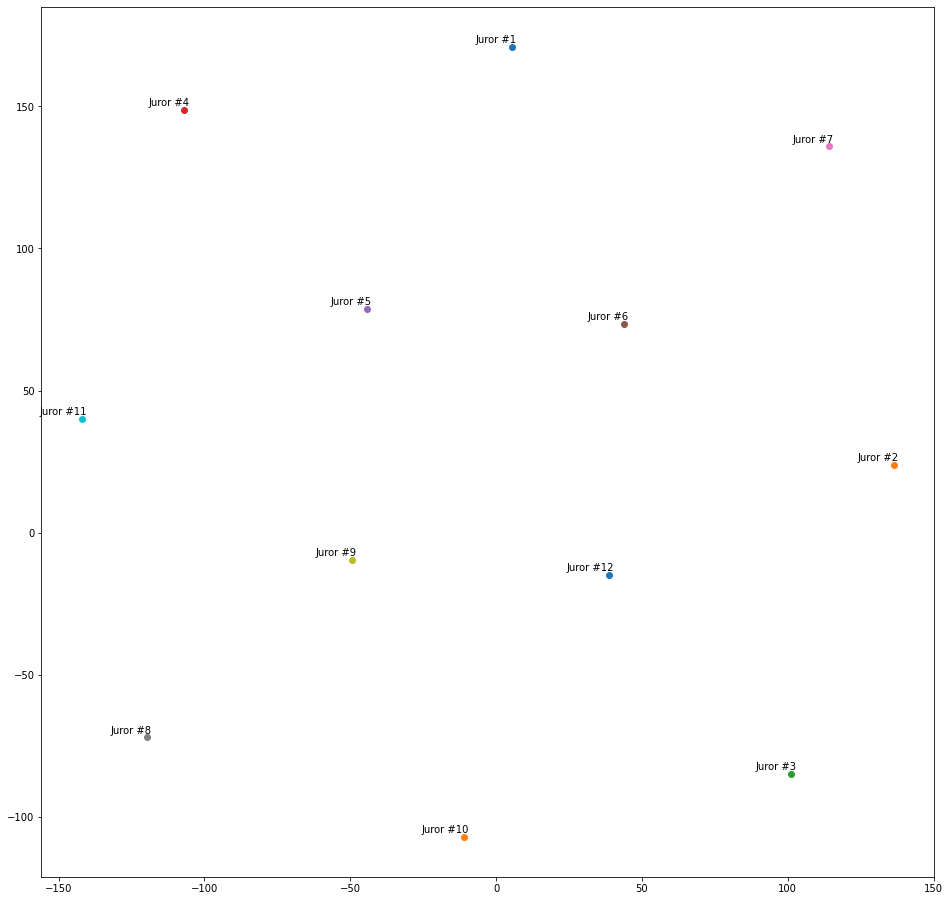

In [14]:
tsne_generator(language_models)